In [1]:
import argparse
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture as GMM
from utils import *
import numpy as np
import torch
import copy
import matplotlib.patches as patches
from scipy.stats import skew 

In [2]:
sd_mdl = torch.load('out/MNIST_vanilla_RKM_h128_oneview.tar', map_location=torch.device('cpu'))

net1 = sd_mdl['net1'].float().cpu()
net3 = sd_mdl['net3'].float().cpu()
net2 = sd_mdl['net2'].float().cpu()
net4 = sd_mdl['net4'].float().cpu()
net1.load_state_dict(sd_mdl['net1_state_dict'])
net3.load_state_dict(sd_mdl['net3_state_dict'])
net2.load_state_dict(sd_mdl['net2_state_dict'])
net4.load_state_dict(sd_mdl['net4_state_dict'])
h = sd_mdl['h'].float().detach().cpu()
s = sd_mdl['s'].float().detach().cpu()
V = sd_mdl['V'].float().detach().cpu()
U = sd_mdl['U'].float().detach().cpu()

sd_mdl_ = torch.load('out/MNIST_adv_RKM_h128_epoch200_pert30_oneview.tar', map_location=torch.device('cpu'))

net1_ = sd_mdl_['net1'].float().cpu()
net3_ = sd_mdl_['net3'].float().cpu()
net2_ = sd_mdl_['net2'].float().cpu()
net4_ = sd_mdl_['net4'].float().cpu()
net1_.load_state_dict(sd_mdl_['net1_state_dict'])
net3_.load_state_dict(sd_mdl_['net3_state_dict'])
net2_.load_state_dict(sd_mdl_['net2_state_dict'])
net4_.load_state_dict(sd_mdl_['net4_state_dict'])
h_ = sd_mdl_['h'].float().detach().cpu()
s_ = sd_mdl_['s'].float().detach().cpu()
V_ = sd_mdl_['V'].float().detach().cpu()
U_ = sd_mdl_['U'].float().detach().cpu()

In [3]:
# Load a Pre-trained model or saved model ====================
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--filename', type=str, default="out/MNIST_adv_linf_RKM_h_500.tar", help='Enter Filename')
parser.add_argument('--device', type=str, default='cpu', help='Device type: cuda or cpu')
opt_gen = parser.parse_args()

if 'opt' in sd_mdl:
    opt = sd_mdl['opt']
    #self.opt_gen = argparse.Namespace(**vars(opt), **vars(self.opt_gen))
    opt_dict = vars(opt)
    opt_dict.update(vars(opt_gen))  # Update opt_gen with values from opt, prioritizing opt_gen
    opt_gen = argparse.Namespace(**opt_dict)
else:
    opt_gen.mb_size = 200
    
#load the data
opt_gen.shuffle = False
xt, _, _ = get_mnist_dataloader(args=opt_gen)  # loading data without shuffle
xtrain = xt.dataset.train_data[:h.shape[0], :, :, :]  #60.000, 1, 28, 28; h shape 0: 5000
ytrain = xt.dataset.targets[:h.shape[0], :]

image_ori = xtrain[0, :, :, :].float()

c:\Users\gcorl\OneDrive\Documents\KUL\Master 2\Master thesis\Programming\Restricted_Kernel_Machines_Demo_MNIST\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
def generate_back(net1, net3, U, s, h, x):
    """
    Receives an imput as image, goes to the feature space, then latent space, afteerwards back to the feature space and back to the image space.
    Travels the complete model to generate back the image.
    Input: (1, 1, 28, 28) (first dimension needed for the neural network)
    Output: (1, 28, 28)
    """
    #go to the feature space
    output1 = net1(x)

    Lambda = torch.diag(s[:h.size(1)])
    lam_inv = torch.linalg.inv(Lambda)

    #compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
    #note here the computation is done with everything transposed
    latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)

    #print(latent1)

    #go back to the feature space U*h
    my_input_net3 = torch.mm(latent1, torch.t(U))

    #go back to the image space
    datax_gen = net3(my_input_net3[0,:])

    return datax_gen

def __distortion_images(first_image, second_image):
        """
        Measure the distortion between two images using the Frobenius norm
        """

        return float(torch.linalg.vector_norm(first_image-second_image).detach().numpy())

def __loss_function(net1, net3, U, s, h, x_ori, x, lam, type1 = True):
    """ 
    Loss function to generate the adversarial image where input different and output same. (type 1 attack)
    Loss function to generate the adversarial image where input similar and output different. (type 2 attack) 
    """
    image_adv_back = generate_back(net1, net3, U, s, h, x)
    my_loss = torch.linalg.vector_norm(image_adv_back-x_ori) - lam * torch.linalg.vector_norm(x-x_ori)  #torch.linalg.vector_norm

    if(not type1):
        my_loss = -1*my_loss #change sign of the loss function in case type 2 attack

    return my_loss

def __get_latent(net1, U, s, h, x):
        
    #go to the feature space
    output1 = net1(x)

    Lambda = torch.diag(s[:h.size(1)])
    lam_inv = torch.linalg.inv(Lambda)

    latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)

    return latent1

def adversarial_attack_lim(net1, net3, U, s, h, nbr_image, max_input_perturbation, lam_fun, eta_fun, type1, xt):
    """
    Adversarial attack using algorithm from the paper of Sun (type 1 attack)

    with lim = limited in the amount of input perturbation instead of the number of iterations

    adv_image_ori = original unperturbed image
    adv_image = image that will be perturbed
    nbr_it = number of iterations (typical value 10)
    lam_fun = lambda value = trade-off between the two terms (typical value 10 for type 1 and 0.1 for type 2)
    eta = rate to apply the perturbation on the image, "learning rate" (typical value 0.1)
    type1 = chose between type 1 and type 2 attack 
    """

    nbr_image = nbr_image
    type1 = type1

    x_ori = xt.dataset.train_data[nbr_image, :, :, :].float()
    #y_ori = xt.dataset.targets[nbr_image, :]

    #datax, _ = x_ori.to(self.opt_gen.device), y_ori.to(self.opt_gen.device) # _ = datay
    image = x_ori[None, :, :, :]
    assert image.shape == (1, 1, 28, 28) #fourth dimension to be used in the neural network

    #starting image for the adversarial attack (equal to the original image)
    image_ori = image.clone().detach()

    #initialize the adversarial image that will be perturbed
    image_adv = torch.tensor(image_ori, requires_grad=True)

    """
    #initialize the distortion lists
    self.distortion_input = []
    self.distortion_output = []
    self.distortion_input.append(self.__distortion_images(self.image_ori, self.image_ori))
    self.distortion_output.append(self.__distortion_images(self.image_ori, self.__generate_back(self.image_ori)))

    self.lpips_input = []
    self.lpips_output = []
    self.lpips_input.append(self.__get_lpips(self.image_ori, self.image_ori))
    self.lpips_output.append(self.__get_lpips(self.image_ori, self.__generate_back(self.image_ori)))

    self.ssim_input = []
    self.ssim_output = []
    self.ssim_input.append(self.__get_ssim(self.image_ori, self.image_ori))
    self.ssim_output.append(self.__get_ssim(self.image_ori, self.__generate_back(self.image_ori)))
    """

    nbr_it = 0

    dist_prev = 0

    #attack on the image
    while(dist_prev < max_input_perturbation and nbr_it<100):   
        image_adv = image_adv.clone().detach().requires_grad_(True)
        loss_value = __loss_function(net1, net3, U, s, h, image_ori, image_adv, lam_fun, type1)
        loss_value.backward() #1.0
        image_adv = image_adv - eta_fun*image_adv.grad
        torch.clamp(image_adv, 0, 1) #clamp all values between 0 and 1

        dist_prev = __distortion_images(image_ori, image_adv)
        """
        if((nbr_it+1)%1==0):
            self.distortion_input.append(self.__distortion_images(self.image_ori, self.image_adv))
            #self.distortion_output.append(self.__distortion_images(self.image_adv_back, self.image_adv))
            self.distortion_output.append(self.__distortion_images(self.image_adv_back, self.image_ori))

            self.lpips_input.append(self.__get_lpips(self.image_ori, self.image_adv))
            #self.lpips_output.append(self.__get_lpips(self.image_adv_back, self.image_adv))
            self.lpips_output.append(self.__get_lpips(self.image_adv_back, self.image_ori))

            self.ssim_input.append(self.__get_ssim(self.image_ori, self.image_adv))
            self.ssim_output.append(self.__get_ssim(self.image_ori, self.image_adv_back))
        """

        nbr_it += 1

    it_attack = nbr_it

    print("attack succeeded")
    return image_ori, image_adv

def adversarial_attack_lim_save(net1, net3, U, s, h, nbr_image, max_input_perturbation, lam_fun, eta_fun, type1, xt):
    """
    Adversarial attack using algorithm from the paper of Sun (type 1 attack) and save the adversarial images

    with lim = limited in the amount of input perturbation instead of the number of iterations

    adv_image_ori = original unperturbed image
    adv_image = image that will be perturbed
    nbr_it = number of iterations (typical value 10)
    lam_fun = lambda value = trade-off between the two terms (typical value 10 for type 1 and 0.1 for type 2)
    eta = rate to apply the perturbation on the image, "learning rate" (typical value 0.1)
    type1 = chose between type 1 and type 2 attack 
    """

    nbr_image = nbr_image
    type1 = type1

    x_ori = xt.dataset.train_data[nbr_image, :, :, :].float()
    #y_ori = xt.dataset.targets[nbr_image, :]

    #datax, _ = x_ori.to(self.opt_gen.device), y_ori.to(self.opt_gen.device) # _ = datay
    image = x_ori[None, :, :, :]
    assert image.shape == (1, 1, 28, 28) #fourth dimension to be used in the neural network

    #starting image for the adversarial attack (equal to the original image)
    image_ori = image.clone().detach()

    #initialize the adversarial image that will be perturbed
    image_adv = torch.tensor(image_ori, requires_grad=True)

    list_adv_images = []
    distortion_input = []

    list_adv_images.append(image_adv)
    distortion_input.append(__distortion_images(image_ori, image_ori))

    nbr_it = 0
    dist_prev = 0

    #attack on the image
    while(dist_prev < max_input_perturbation and nbr_it<100):   
        image_adv = image_adv.clone().detach().requires_grad_(True)
        loss_value = __loss_function(net1, net3, U, s, h, image_ori, image_adv, lam_fun, type1)
        loss_value.backward() #1.0
        image_adv = image_adv - eta_fun*image_adv.grad
        torch.clamp(image_adv, 0, 1) #clamp all values between 0 and 1

        dist_prev = __distortion_images(image_ori, image_adv)
        distortion_input.append(dist_prev)
        list_adv_images.append(image_adv)

        nbr_it += 1

    it_attack = nbr_it

    print("attack succeeded")
    return list_adv_images, distortion_input

In [23]:
image_ori, image_adv = adversarial_attack_lim(net1, net3, U, s, h, 3, 3, 0.1, 0.1, False, xt)
image_adv_back = generate_back(net1, net3, U, s, h, image_adv)

C:\Users\gcorl\AppData\Local\Temp\ipykernel_16808\2838322834.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded


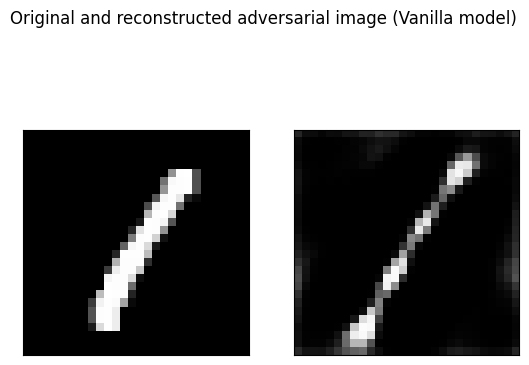

In [24]:
image_ori = image_ori.reshape(1, 28, 28)
image_adv_back = image_adv_back.reshape(1, 28, 28)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_adv_back[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed adversarial image (Vanilla model)")
plt.show()

c:\Users\gcorl\OneDrive\Documents\KUL\Master 2\Master thesis\Programming\Restricted_Kernel_Machines_Demo_MNIST\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\gcorl\AppData\Local\Temp\ipykernel_16808\2838322834.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded


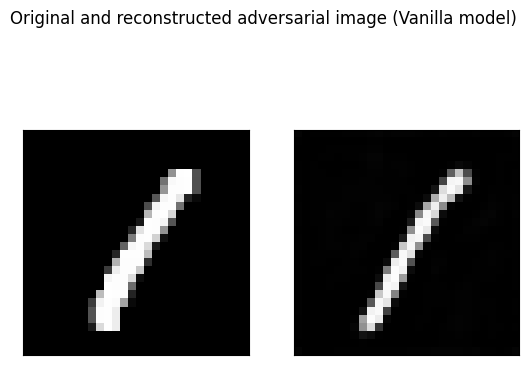

In [25]:
image_ori, image_adv = adversarial_attack_lim(net1_, net3_, U_, s_, h_, 3, 3, 0.1, 0.1, False, xt)
image_adv_back = generate_back(net1_, net3_, U_, s_, h_, image_adv)

image_ori = image_ori.reshape(1, 28, 28)
image_adv_back = image_adv_back.reshape(1, 28, 28)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_adv_back[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed adversarial image (Robust model)")
plt.show()

Comparison latent components on an attack

In [64]:
image_ori, image_adv_van = adversarial_attack_lim(net1, net3, U, s, h, 3, 3, 0.1, 0.1, False, xt)
image_adv_back_van = generate_back(net1, net3, U, s, h, image_adv_van)
latent_van = __get_latent(net1, U, s, h, image_adv)
image_ori, image_adv_rob = adversarial_attack_lim(net1_, net3_, U_, s_, h_, 3, 3, 0.1, 0.1, False, xt)
image_adv_back_rob = generate_back(net1_, net3_, U_, s_, h_, image_adv_rob)
latent_rob = __get_latent(net1_, U_, s_, h_, image_adv_rob)

image_adv_back_van_on_rob = generate_back(net1, net3, U, s, h, image_adv_rob)
latent_van_on_rob = __get_latent(net1, U, s, h, image_adv)
image_adv_back_rob_on_van = generate_back(net1_, net3_, U_, s_, h_, image_adv_rob)
latent_rob_on_van = __get_latent(net1_, U_, s_, h_, image_adv_van)

c:\Users\gcorl\OneDrive\Documents\KUL\Master 2\Master thesis\Programming\Restricted_Kernel_Machines_Demo_MNIST\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\gcorl\AppData\Local\Temp\ipykernel_16808\2838322834.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded
attack succeeded


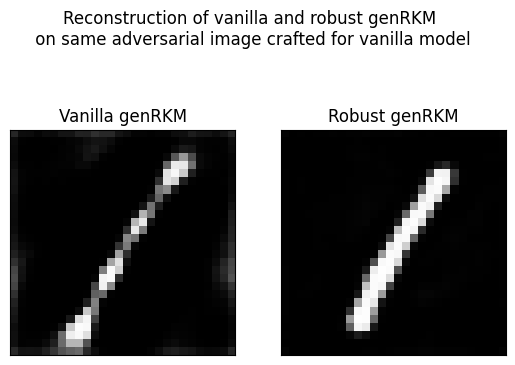

In [63]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_adv_back_van.reshape(1, 28, 28)[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_adv_back_rob_on_van.reshape(1, 28, 28)[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title('Vanilla genRKM')
ax[1].set_title('Robust genRKM')
plt.suptitle(f"Reconstruction of vanilla and robust genRKM\n on same adversarial image crafted for vanilla model")
plt.show()

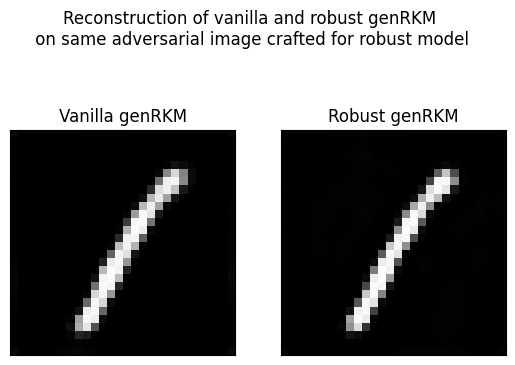

In [65]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_adv_back_van_on_rob.reshape(1, 28, 28)[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_adv_back_rob.reshape(1, 28, 28)[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title('Vanilla genRKM')
ax[1].set_title('Robust genRKM')
plt.suptitle(f"Reconstruction of vanilla and robust genRKM\n on same adversarial image crafted for robust model")
plt.show()

Both for their optimal attack image

In [29]:
diff_latent_van = __get_latent(net1, U, s, h, image_adv_van) - __get_latent(net1, U, s, h, image_ori)
diff_latent_rob = __get_latent(net1_, U_, s_, h_, image_adv_rob) - __get_latent(net1_, U_, s_, h_, image_ori)

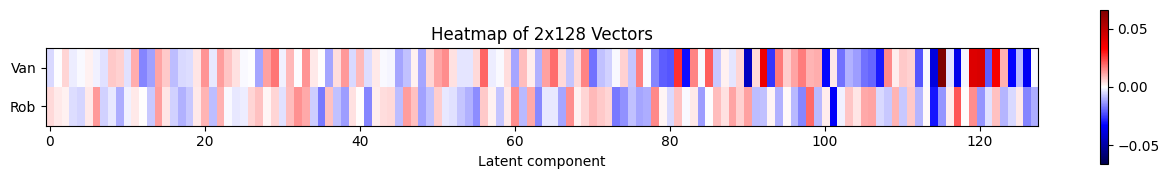

In [49]:
# Combine the vectors into a 2x128 matrix
vector1_np = diff_latent_van.detach().numpy()
vector2_np = diff_latent_rob.detach().numpy()

# Combine the vectors into a 2x128 matrix
data = np.vstack([vector1_np, vector2_np])

# Plot the heatmap
plt.figure(figsize=(16, 2)) 
plt.imshow(data, cmap='seismic', aspect=5, vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data))) #bwr
plt.colorbar()
plt.title('Difference in latent space between vanilla and robust genRKM when both attacked with optimal adversarial input')
plt.xlabel('Latent component')
plt.yticks([0, 1], ['Van', 'Rob'])
#plt.yticks([])
#plt.ylabel('Vector')
plt.show()

In [55]:
vector1_np = np.squeeze(vector1_np)
vector2_np = np.squeeze(vector2_np)

both for their optimal attack image

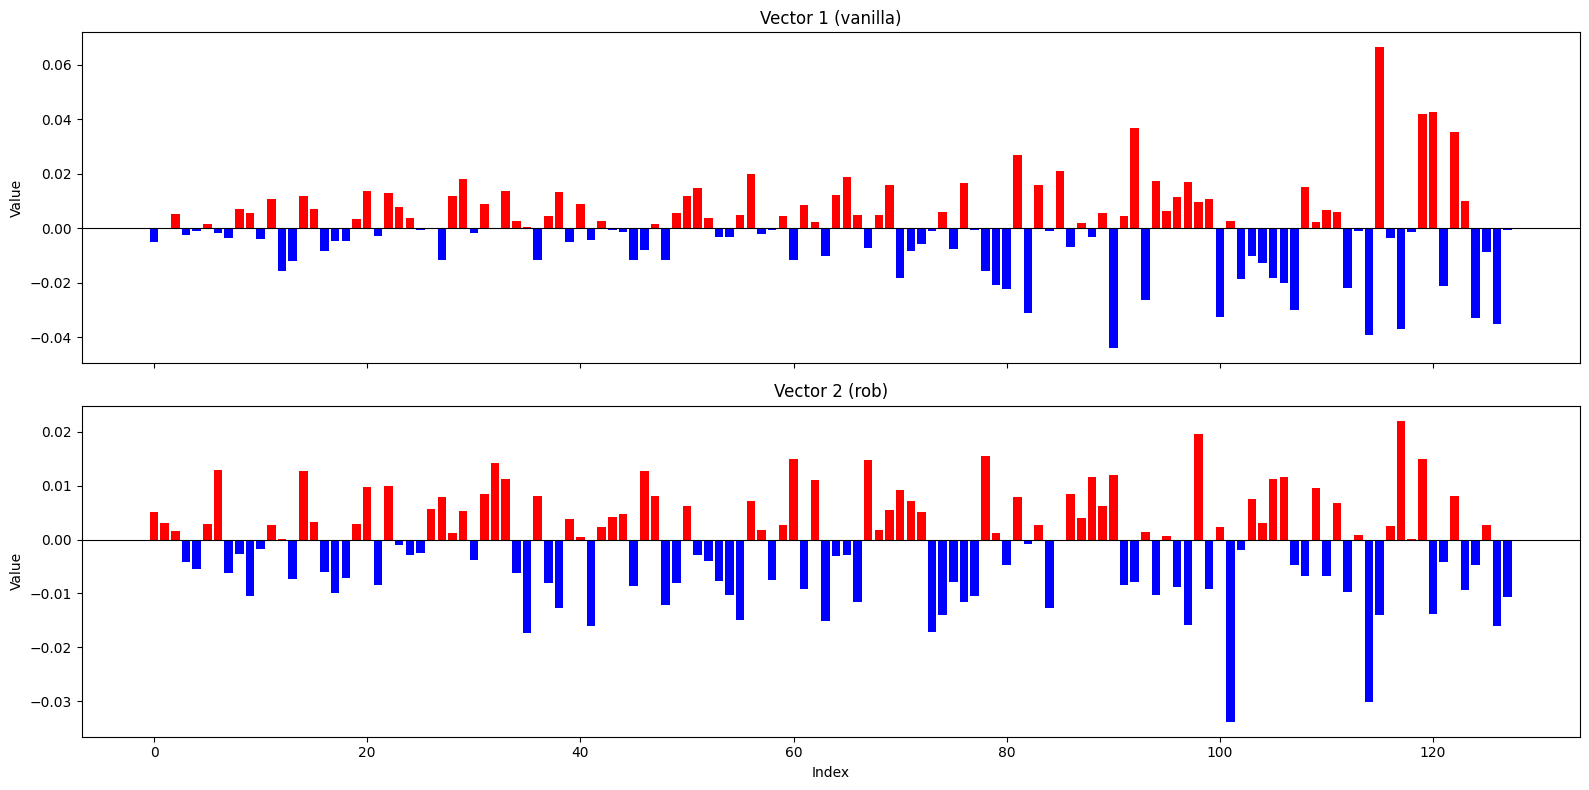

In [57]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharex=True)

# Colors for vector1
colors1 = np.where(vector1_np > 0, 'red', 'blue')
colors2 = np.where(vector2_np > 0, 'red', 'blue')

# Plot for the first vector
bars1 = axes[0].bar(range(128), vector1_np, color=colors1) #, color=colors1
axes[0].axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
axes[0].set_title('Vector 1 (vanilla)')
axes[0].set_ylabel('Value')

# Plot for the second vector
bars2 = axes[1].bar(range(128), vector2_np, color=colors2)  #, color=colors2
axes[1].axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
axes[1].set_title('Vector 2 (rob)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.show()

For the adversarial image crafted on vanilla model

In [66]:
diff_latent_van_on_van = __get_latent(net1, U, s, h, image_adv_van) - __get_latent(net1, U, s, h, image_ori)
diff_latent_rob_on_van = __get_latent(net1_, U_, s_, h_, image_adv_van) - __get_latent(net1_, U_, s_, h_, image_ori)

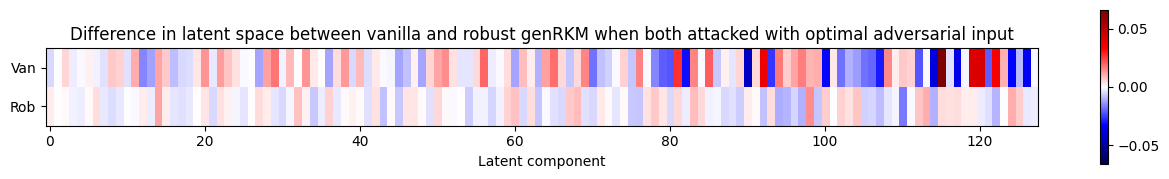

In [68]:
# Combine the vectors into a 2x128 matrix
vector1_np = diff_latent_van_on_van.detach().numpy()
vector2_np = diff_latent_rob_on_van.detach().numpy()

# Combine the vectors into a 2x128 matrix
data = np.vstack([vector1_np, vector2_np])

# Plot the heatmap
plt.figure(figsize=(16, 2)) 
plt.imshow(data, cmap='seismic', aspect=5, vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data))) #bwr
plt.colorbar()
plt.title('Difference in latent space between vanilla and robust genRKM when both attacked with optimal adversarial input')
plt.xlabel('Latent component')
plt.yticks([0, 1], ['Van', 'Rob'])
#plt.yticks([])
#plt.ylabel('Vector')
plt.show()

In [69]:
vector1_np = np.squeeze(vector1_np)
vector2_np = np.squeeze(vector2_np)

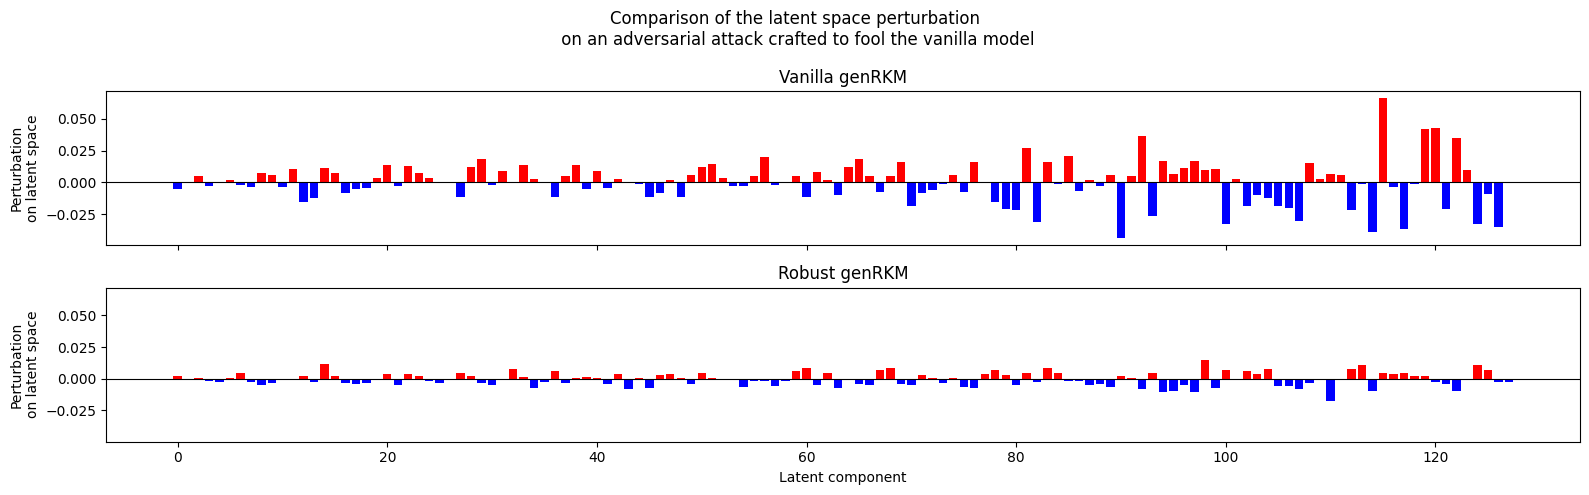

In [79]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 5), sharex=True)

# Colors for vector1
colors1 = np.where(vector1_np > 0, 'red', 'blue')
colors2 = np.where(vector2_np > 0, 'red', 'blue')

# Plot for the first vector
bars1 = axes[0].bar(range(128), vector1_np, color=colors1) #, color=colors1
axes[0].axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
axes[0].set_title('Vanilla genRKM')
axes[0].set_ylabel('Perturbation\non latent space')

# Plot for the second vector
bars2 = axes[1].bar(range(128), vector2_np, color=colors2)  #, color=colors2
axes[1].axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
axes[1].set_title('Robust genRKM')
axes[1].set_xlabel('Latent component')
axes[1].set_ylabel('Perturbation\non latent space')
axes[1].set_ylim(axes[0].get_ylim())

plt.suptitle("Comparison of the latent space perturbation\n on an adversarial attack crafted to fool the vanilla model")
# Adjust layout
plt.tight_layout()
plt.show()

Visualize how the latent vector walks around

In [5]:
reference_points = np.arange(0, 3.25, 0.25)
print(reference_points)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.  ]


In [6]:
def get_index_closest(reference, input):
    
    index = []

    for target in reference:
        dist = np.inf
        best_index = np.inf

        counter = 0
        for value in input:
            if(np.abs(value-target)<dist):
                dist = np.abs(value-target)
                best_index = counter
            counter += 1
            
        index.append(best_index)

    return index

In [64]:
list_adv_image, input_distortion = adversarial_attack_lim_save(net1, net3, U, s, h, 2, 3, 0.1, 0.1, False, xt)

C:\Users\gcorl\AppData\Local\Temp\ipykernel_18076\3033574608.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded


In [67]:
list_adv_image, input_distortion = adversarial_attack_lim_save(net1_, net3_, U_, s_, h_, 3, 3, 0.1, 0.1, False, xt)

C:\Users\gcorl\AppData\Local\Temp\ipykernel_18076\3033574608.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded


In [68]:
index_list = get_index_closest(reference_points, input_distortion)

0.025700483
0.01940059


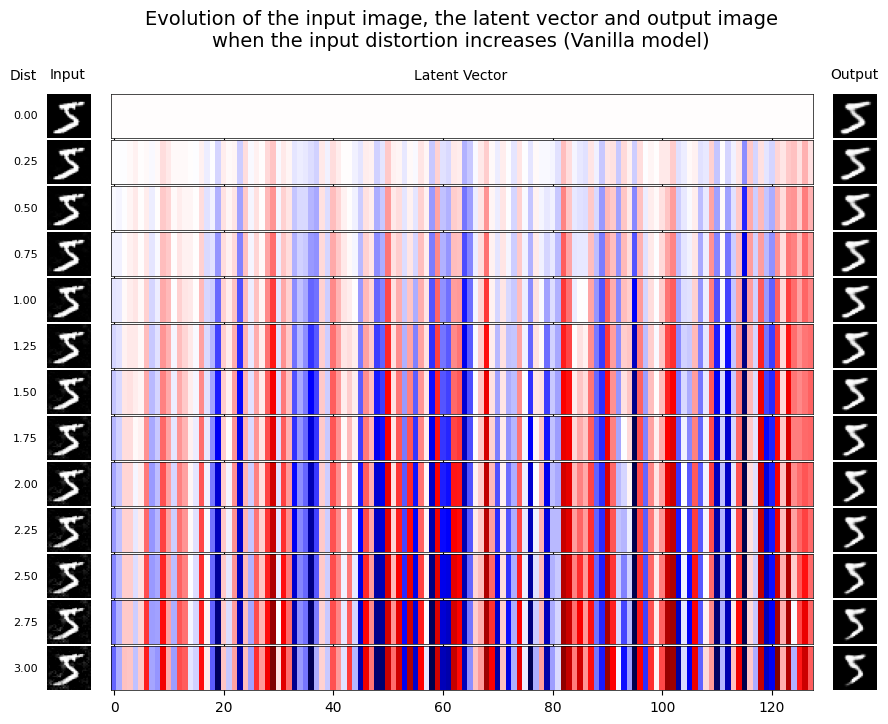

In [62]:
num_rows = len(reference_points)

# Create the figure and the subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 0.5 * num_rows), gridspec_kw={'width_ratios': [1, 6, 1]})

# Add labels above the columns
fig.text(1/14+0.035, 1, 'Input', ha='center', fontsize=10)
fig.text(0.5, 1, 'Latent Vector', ha='center', fontsize=10)
fig.text(13/14-0.035, 1, 'Output', ha='center', fontsize=10)
fig.text(0.0625, 1, 'Dist', ha='center', fontsize=10)

#compute boundary heatmap
diff_latent_van = __get_latent(net1, U, s, h, list_adv_image[-1]) - __get_latent(net1, U, s, h, list_adv_image[0])
max_diff_lat = np.max(diff_latent_van.detach().numpy())
print(max_diff_lat)

diff_latent_van_ = __get_latent(net1_, U_, s_, h_, list_adv_image[-1]) - __get_latent(net1_, U_, s_, h_, list_adv_image[0])
max_diff_lat_ = np.max(diff_latent_van_.detach().numpy())
print(max_diff_lat_)

max_diff_lat = np.max([max_diff_lat, max_diff_lat_])

# Plot each row
for i in range(num_rows):

    index = index_list[i]

    image_ori = list_adv_image[0]
    image_input = list_adv_image[index]
    image_output = generate_back(net1, net3, U, s, h, image_input)

    diff_latent_van = __get_latent(net1, U, s, h, image_input) - __get_latent(net1, U, s, h, image_ori)
    #diff_latent_rob = __get_latent(net1_, U_, s_, h_, image_input) - __get_latent(net1_, U_, s_, h_, image_ori)
    latent_vector = diff_latent_van.detach().numpy()

    # Plot the left image
    axes[i, 0].imshow(image_input.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 0].axis('off')

    axes[i, 0].text(-0.5, 0.5, f'{reference_points[i]:.2f}', ha='center', va='center', fontsize=8, color='black', transform=axes[i, 0].transAxes)
    
    # Plot the heatmap
    axes[i, 1].imshow(latent_vector, aspect = 8, cmap='seismic', vmin=-max_diff_lat, vmax=max_diff_lat)
    #axes[i, 1].axis('off')
    #axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

    # Add a frame around the heatmap
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')  # Set the frame color
        spine.set_linewidth(0.5)        # Set the frame thickness
    
    # Plot the right image
    axes[i, 2].imshow(image_output.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 2].axis('off')

# Adjust the layout
plt.tight_layout()

plt.subplots_adjust(hspace=0.05, wspace=-0.5)

#plt.suptitle("Evolution of the input image, the latent vector and output image\nwhen the input distortion increases (Vanilla model)")
fig.text(0.5, 1.05, 'Evolution of the input image, the latent vector and output image\nwhen the input distortion increases (Vanilla model)', ha='center', fontsize=14)

plt.show()

0.018528763
0.022103038


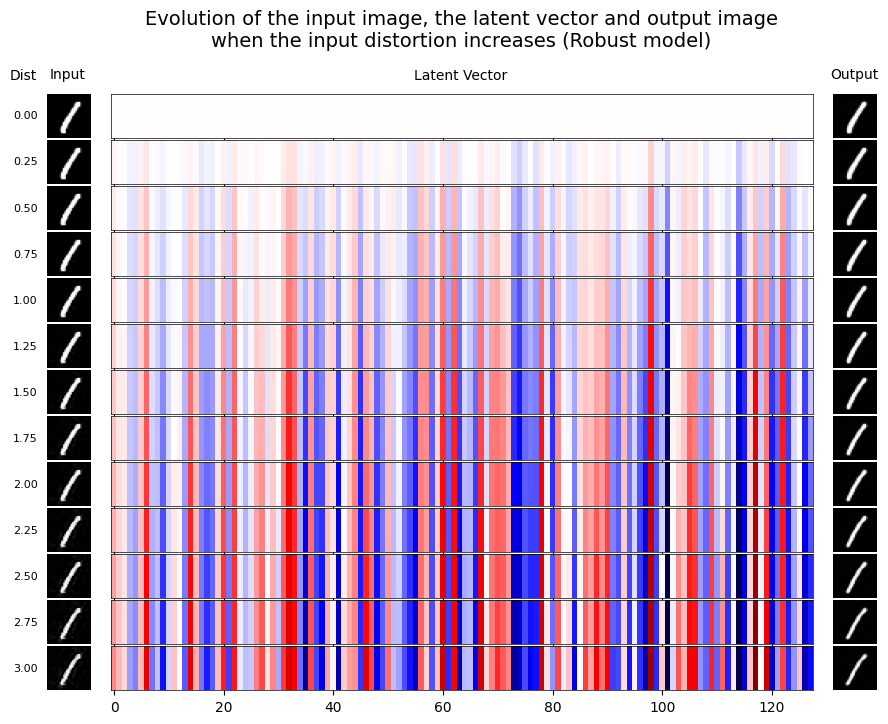

In [69]:
num_rows = len(reference_points)

# Create the figure and the subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 0.5 * num_rows), gridspec_kw={'width_ratios': [1, 6, 1]})

# Add labels above the columns
fig.text(1/14+0.035, 1, 'Input', ha='center', fontsize=10)
fig.text(0.5, 1, 'Latent Vector', ha='center', fontsize=10)
fig.text(13/14-0.035, 1, 'Output', ha='center', fontsize=10)
fig.text(0.0625, 1, 'Dist', ha='center', fontsize=10)

#compute boundary heatmap
diff_latent_van = __get_latent(net1, U, s, h, list_adv_image[-1]) - __get_latent(net1, U, s, h, list_adv_image[0])
max_diff_lat = np.max(diff_latent_van.detach().numpy())
print(max_diff_lat)

diff_latent_van_ = __get_latent(net1_, U_, s_, h_, list_adv_image[-1]) - __get_latent(net1_, U_, s_, h_, list_adv_image[0])
max_diff_lat_ = np.max(diff_latent_van_.detach().numpy())
print(max_diff_lat_)

max_diff_lat = np.max([max_diff_lat, max_diff_lat_])

# Plot each row
for i in range(num_rows):

    index = index_list[i]

    image_ori = list_adv_image[0]
    image_input = list_adv_image[index]
    image_output = generate_back(net1_, net3_, U_, s_, h_, image_input)

    diff_latent_van = __get_latent(net1_, U_, s_, h_, image_input) - __get_latent(net1_, U_, s_, h_, image_ori)
    #diff_latent_rob = __get_latent(net1_, U_, s_, h_, image_input) - __get_latent(net1_, U_, s_, h_, image_ori)
    latent_vector = diff_latent_van.detach().numpy()

    # Plot the left image
    axes[i, 0].imshow(image_input.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 0].axis('off')

    axes[i, 0].text(-0.5, 0.5, f'{reference_points[i]:.2f}', ha='center', va='center', fontsize=8, color='black', transform=axes[i, 0].transAxes)
    
    # Plot the heatmap
    axes[i, 1].imshow(latent_vector, aspect = 8, cmap='seismic', vmin=-max_diff_lat, vmax=max_diff_lat)
    #axes[i, 1].axis('off')
    #axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

    # Add a frame around the heatmap
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')  # Set the frame color
        spine.set_linewidth(0.5)        # Set the frame thickness
    
    # Plot the right image
    axes[i, 2].imshow(image_output.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 2].axis('off')

# Adjust the layout
plt.tight_layout()

plt.subplots_adjust(hspace=0.05, wspace=-0.5)

#plt.suptitle("Evolution of the input image, the latent vector and output image\nwhen the input distortion increases (Vanilla model)")
fig.text(0.5, 1.05, 'Evolution of the input image, the latent vector and output image\nwhen the input distortion increases (Robust model)', ha='center', fontsize=14)

plt.show()

C:\Users\gcorl\AppData\Local\Temp\ipykernel_18076\3033574608.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded


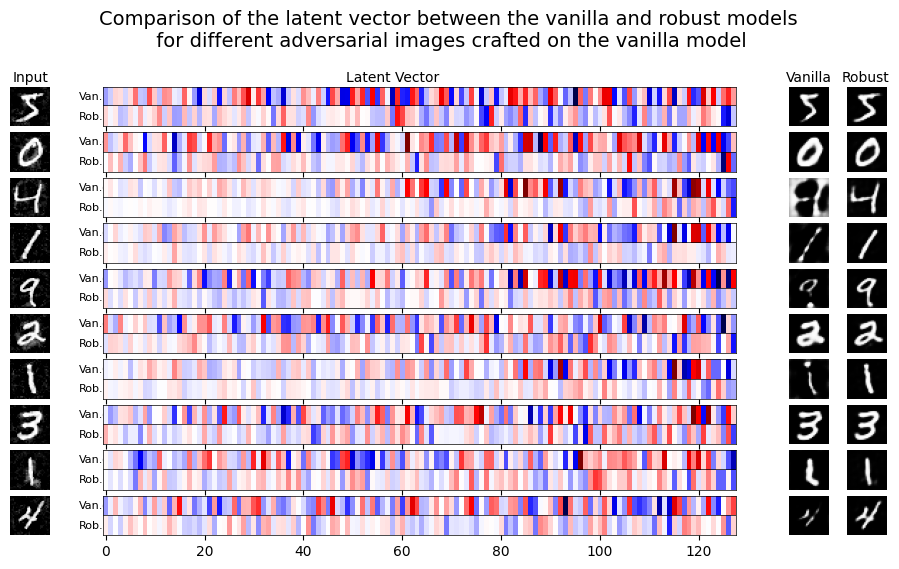

In [37]:
num_images = 10

ind_extra_height = [0, 3, 5, 7, 8, 9]

# Create the figure and the subplots
fig, axes = plt.subplots(num_images, 4, figsize=(10, 0.5 * num_images), gridspec_kw={'width_ratios': [1, 6, 1, 1]})

# Add labels above the columns
fig.text(1/16+0.02, 0.98, 'Input', ha='center', fontsize=10)
fig.text(4/9, 0.98, 'Latent Vector', ha='center', fontsize=10)
fig.text(13/16+0.0475, 0.98, 'Vanilla', ha='center', fontsize=10)
fig.text(15/16-0.02, 0.98, 'Robust', ha='center', fontsize=10)


# Plot each row
for i in range(num_images):

    image_ori, image_adv = adversarial_attack_lim(net1, net3, U, s, h, i, 3, 0.1, 0.1, False, xt)
    image_adv_back_van = generate_back(net1, net3, U, s, h, image_adv)
    latent_van = __get_latent(net1, U, s, h, image_adv)
    
    image_adv_back_rob = generate_back(net1_, net3_, U_, s_, h_, image_adv)
    latent_rob = __get_latent(net1_, U_, s_, h_, image_adv)

    diff_latent_van = latent_van - __get_latent(net1, U, s, h, image_ori)
    diff_latent_rob = latent_rob - __get_latent(net1_, U_, s_, h_, image_ori)
    latent_vector = diff_latent_van.detach().numpy()

    # Combine the vectors into a 2x128 matrix
    vector1_np = diff_latent_van.detach().numpy()
    vector2_np = diff_latent_rob.detach().numpy()

    # Combine the vectors into a 2x128 matrix
    data = np.vstack([vector1_np, vector2_np])

    # Plot the left image
    axes[i, 0].imshow(image_adv.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 0].axis('off')    

    # Plot the heatmap
    im = axes[i, 1].imshow(data, aspect = 4, cmap='seismic', vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
    #axes[i, 1].axis('off')
    #axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 1].text(-3, 0, 'Van.', ha='center', va='center', fontsize=8, color='black')#, transform=axes[i, 0].transAxes)
    axes[i, 1].text(-3, 1, 'Rob.', ha='center', va='center', fontsize=8, color='black')#, transform=axes[i, 0].transAxes)

    # Add a frame around the heatmap
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')  # Set the frame color
        spine.set_linewidth(0.5)        # Set the frame thickness
    
    #attempt 1
    # Add a black line between the two rows of the heatmap
    #axes[i, 1].axhline(0.5, color='black', linewidth=0.5)

    #attempt 2
    #image_height = data.shape[0]  # Should be 2, since it's a 2x128 matrix
    #center_position = 0.5 * (image_height - 1)  # This should be 0.5

    # Add a black line exactly in the middle of the two rows of the heatmap
    #axes[i, 1].axhline(center_position, color='black', linewidth=0.5)

    #attempt 3
    # Get the y-axis limits to calculate the precise middle
    ymin, ymax = axes[i, 1].get_ylim()
    center_position = ymin + 0.5 * (ymax - ymin)

    extra = 0
    if(i in ind_extra_height):
        extra = 0.05

    # Manually plot the line at the exact center of the two rows
    axes[i, 1].plot([-0.5, data.shape[1] - 0.5], [center_position-extra, center_position-extra], color='black', linewidth=0.5)

    #attempt 4
    # Get the extent of the heatmap in data coordinates
    #extent = im.get_extent()

    # Calculate the center position between the two rows
    #row_height = (extent[3] - extent[2]) / data.shape[0]  # Calculate the height of each row
    #center_position = extent[2] + row_height  # Middle of the two rows

    # Manually plot the line at the calculated center between the rows
    #axes[i, 1].plot([-0.5, data.shape[1] - 0.5], [center_position, center_position], color='black', linewidth=0.5)
    
    # Plot the right image
    axes[i, 2].imshow(image_adv_back_van.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 2].axis('off')

    # Plot the right image
    axes[i, 3].imshow(image_adv_back_rob.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 3].axis('off')

# Adjust the layout
plt.tight_layout()

plt.subplots_adjust(hspace=0.15, wspace=-0.25) #0.05, -0.25

fig.text(0.5, 1.05, 'Comparison of the latent vector between the vanilla and robust models\n for different adversarial images crafted on the vanilla model', ha='center', fontsize=14)

plt.show()

C:\Users\gcorl\AppData\Local\Temp\ipykernel_18076\3033574608.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded


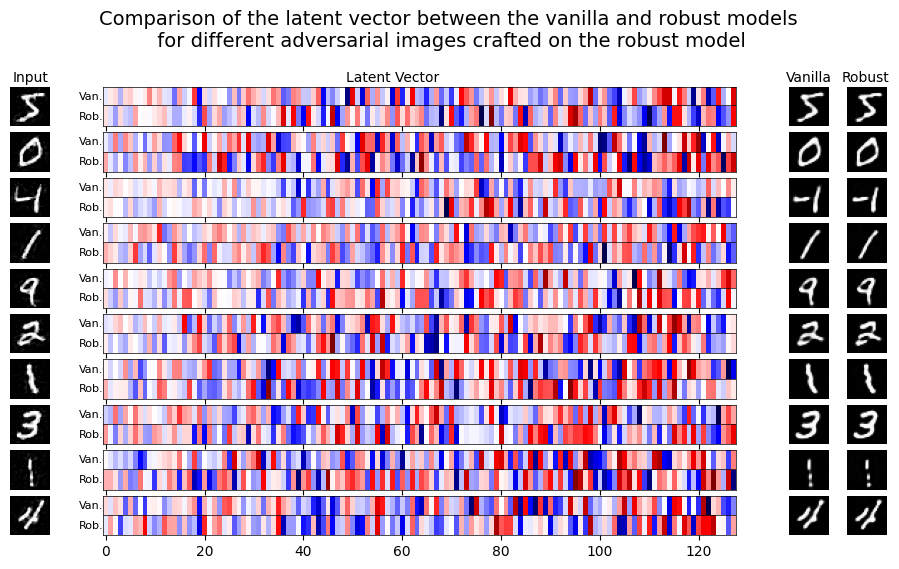

In [39]:
num_images = 10

ind_extra_height = [0, 3, 5, 7, 8, 9]

# Create the figure and the subplots
fig, axes = plt.subplots(num_images, 4, figsize=(10, 0.5 * num_images), gridspec_kw={'width_ratios': [1, 6, 1, 1]})

# Add labels above the columns
fig.text(1/16+0.02, 0.98, 'Input', ha='center', fontsize=10)
fig.text(4/9, 0.98, 'Latent Vector', ha='center', fontsize=10)
fig.text(13/16+0.0475, 0.98, 'Vanilla', ha='center', fontsize=10)
fig.text(15/16-0.02, 0.98, 'Robust', ha='center', fontsize=10)


# Plot each row
for i in range(num_images):

    image_ori, image_adv = adversarial_attack_lim(net1_, net3_, U_, s_, h_, i, 3, 0.1, 0.1, False, xt)
    image_adv_back_van = generate_back(net1, net3, U, s, h, image_adv)
    latent_van = __get_latent(net1, U, s, h, image_adv)
    
    image_adv_back_rob = generate_back(net1_, net3_, U_, s_, h_, image_adv)
    latent_rob = __get_latent(net1_, U_, s_, h_, image_adv)

    diff_latent_van = latent_van - __get_latent(net1, U, s, h, image_ori)
    diff_latent_rob = latent_rob - __get_latent(net1_, U_, s_, h_, image_ori)
    latent_vector = diff_latent_van.detach().numpy()

    # Combine the vectors into a 2x128 matrix
    vector1_np = diff_latent_van.detach().numpy()
    vector2_np = diff_latent_rob.detach().numpy()

    # Combine the vectors into a 2x128 matrix
    data = np.vstack([vector1_np, vector2_np])

    # Plot the left image
    axes[i, 0].imshow(image_adv.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 0].axis('off')    

    # Plot the heatmap
    axes[i, 1].imshow(data, aspect = 4, cmap='seismic', vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
    #axes[i, 1].axis('off')
    #axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 1].text(-3, 0, 'Van.', ha='center', va='center', fontsize=8, color='black')
    axes[i, 1].text(-3, 1, 'Rob.', ha='center', va='center', fontsize=8, color='black')

    # Add a frame around the heatmap
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')  # Set the frame color
        spine.set_linewidth(0.5)        # Set the frame thickness

    #attempt 3
    # Get the y-axis limits to calculate the precise middle
    ymin, ymax = axes[i, 1].get_ylim()
    center_position = ymin + 0.5 * (ymax - ymin)

    extra = 0
    if(i in ind_extra_height):
        extra = 0.05

    # Manually plot the line at the exact center of the two rows
    axes[i, 1].plot([-0.5, data.shape[1] - 0.5], [center_position-extra, center_position-extra], color='black', linewidth=0.5)
    
    # Plot the right image
    axes[i, 2].imshow(image_adv_back_van.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 2].axis('off')

    # Plot the right image
    axes[i, 3].imshow(image_adv_back_rob.reshape(28,28).detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
    axes[i, 3].axis('off')

# Adjust the layout
plt.tight_layout()

plt.subplots_adjust(hspace=0.15, wspace=-0.25)

fig.text(0.5, 1.05, 'Comparison of the latent vector between the vanilla and robust models\n for different adversarial images crafted on the robust model', ha='center', fontsize=14)

plt.show()

In [25]:
num_images = 25

ind_extra_height = [0, 3, 5, 7, 8, 9]

list_van_perc = []
list_rob_perc = []

list_van_sum = []
list_rob_sum = []

# Plot each row
for i in range(num_images):

    image_ori, image_adv = adversarial_attack_lim(net1_, net3_, U_, s_, h_, i, 3, 0.1, 0.1, False, xt)
    #image_ori, image_adv = adversarial_attack_lim(net1, net3, U, s, h, i, 3, 0.1, 0.1, False, xt)
    image_adv_back_van = generate_back(net1, net3, U, s, h, image_adv)
    latent_van = __get_latent(net1, U, s, h, image_adv)
    
    image_adv_back_rob = generate_back(net1_, net3_, U_, s_, h_, image_adv)
    latent_rob = __get_latent(net1_, U_, s_, h_, image_adv)

    diff_latent_van = latent_van - __get_latent(net1, U, s, h, image_ori)
    diff_latent_rob = latent_rob - __get_latent(net1_, U_, s_, h_, image_ori)
    latent_vector = diff_latent_van.detach().numpy()

    # Combine the vectors into a 2x128 matrix
    vector1_np = diff_latent_van.detach().numpy().squeeze()
    vector2_np = diff_latent_rob.detach().numpy().squeeze()

    #print(f"mean: {np.mean(vector1_np)}; mean: {np.std(vector1_np)}; mean: {skew(np.abs(vector1_np))}")
    #print(f"mean: {np.mean(vector2_np)}; mean: {np.std(vector2_np)}; mean: {skew(np.abs(vector2_np))}")

    van_part_1 = np.sum(np.abs(vector1_np[0:int(len(vector1_np)/2)]))
    van_part_2 = np.sum(np.abs(vector1_np[int(len(vector1_np)/2):]))

    rob_part_1 = np.sum(np.abs(vector2_np[0:int(len(vector2_np)/2)]))
    rob_part_2 = np.sum(np.abs(vector2_np[int(len(vector2_np)/2):]))

    perc_van_part_1 = van_part_1/(van_part_1 + van_part_2)
    perc_rob_part_1 = rob_part_1/(rob_part_1 + rob_part_2)

    list_van_perc.append(perc_van_part_1)
    list_rob_perc.append(perc_rob_part_1)

    list_van_sum.append(van_part_1+van_part_2)
    list_rob_sum.append(rob_part_1+rob_part_2)

    #print(f"Van: {np.round(perc_van_part_1,2)}; Rob: {np.round(perc_rob_part_1,2)}")
    #print(f"vanilla: {np.sum(np.abs(vector1_np[0:int(len(vector1_np)/2)])),np.sum(np.abs(vector1_np[int(len(vector1_np)/2):]))}")
    #print(f"robust: {np.sum(np.abs(vector2_np[0:int(len(vector2_np)/2)])),np.sum(np.abs(vector2_np[int(len(vector2_np)/2):]))}")
    
print(f"Percentage - Van: {np.mean(list_van_perc)}; Rob: {np.mean(list_rob_perc)}")
print(f"Total sum (mean) - Van: {np.mean(list_van_sum)}; Rob: {np.mean(list_rob_sum)}")
print(f"Total sum (std) - Van: {np.std(list_van_sum)}; Rob: {np.std(list_rob_sum)}")


C:\Users\gcorl\AppData\Local\Temp\ipykernel_17212\3033574608.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_adv = torch.tensor(image_ori, requires_grad=True)


attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
attack succeeded
Percentage - Van: 0.4068416953086853; Rob: 0.4316009283065796
Total sum (mean) - Van: 0.9243325591087341; Rob: 1.0221810340881348
Total sum (std) - Van: 0.09572528302669525; Rob: 0.13828283548355103


In [22]:
print(f"Van: {np.mean(list_van_perc)}; Rob: {np.mean(list_rob_perc)}")
print(f"Van: {np.std(list_van_perc)}; Rob: {np.std(list_rob_perc)}")

Van: 0.37254342436790466; Rob: 0.37015366554260254
Van: 0.08119618147611618; Rob: 0.05511229857802391
